# 15-688 Final Project
# Earnings call transcript analysis using text classification
 
 Group Members:
 - Xindi Lan
 - Ziling Xu
 - Junhao Shou

# Introduction

Our topic is earnings call transcript analysis using text classification. In this project, we analyze the earnings call transcripts to give positive or negative investment signals to research analysts and investment managers.

## Motivation
The reason that we want to study this problem is because we found some relationship between the change of the stock price and the publish of earnings call transcript. We got the stock price of several companies in the latest 10 quarters, and also got the date of each quarter's transcript. We actually integrated them into one pot to see the relationship.

In [2]:
import os
import re
import pandas_datareader as web
import matplotlib.pyplot as plt
import datetime
import time
from dateutil.relativedelta import relativedelta
from matplotlib.pyplot import figure
from textblob import TextBlob
from scipy.stats import pearsonr
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import seaborn as sns
from collections import Counter
from wordcloud import WordCloud

path = "./pdf_data/"
ticker_list= os.listdir(path)
if ".DS_Store" in ticker_list:
    ticker_list.remove(".DS_Store")
if ".ipynb_checkpoints" in ticker_list:
    ticker_list.remove(".ipynb_checkpoints")

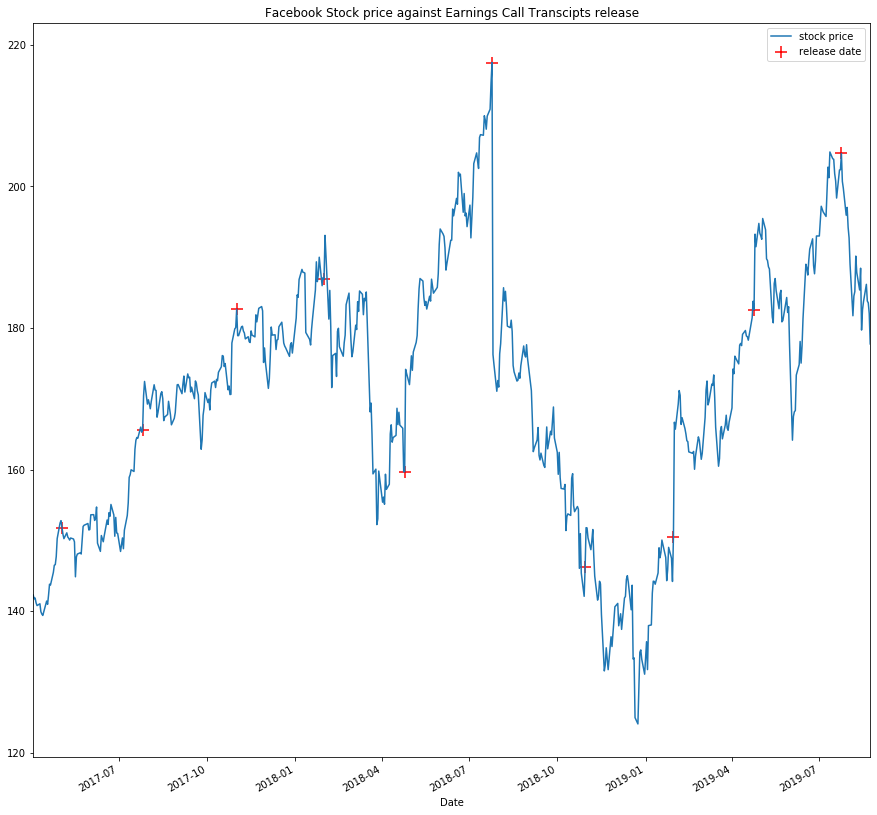

In [5]:
ticker='FB'
test_files=os.listdir(path+ticker+'/')
test_files.sort(reverse=True)
raw_date=[]
for file in test_files:
    temp=file[0:4]+'-'+file[4:6]+'-'+file[6:8]
    while(len(raw_date)<10 and temp not in raw_date):
        raw_date.append(temp)
raw_date.sort()
start=datetime.datetime.strptime(raw_date[0], '%Y-%m-%d').date()+relativedelta(days=-30)
end=datetime.datetime.strptime(raw_date[-1], '%Y-%m-%d').date()+relativedelta(days=30)
ticker_data = web.DataReader(ticker, "yahoo",start,end).loc[:, 'Close']
Y=[]
for index in raw_date:
    Y.append(ticker_data[index])
fig = plt.figure(0)
plt.figure(figsize=(15,15))
ticker_data.plot(label='stock price')
plt.title("Facebook Stock price against Earnings Call Transcipts release")
plt.scatter(raw_date, Y,label = 'release date', c = 'red', marker='+',s=160)
plt.legend()
plt. close(0)

Integrating these data into one plot, we found there always exist the turning points of the stock price after the publish of the transcripts. We may assume the sentiment of the transcript may affect the stock price. Therefore, we want to look into the problem to find whether one transcript is positive or negative and use this as the investment signals for investors.

## Overview
Researches and studies of analysis based on financial documents in finance fields has been a decent amount in the past decade. The content of the research varied from the readbility of the text to the sentiment of the text and analyzed the impact of these features on the financial market. And now with the big data boom, text analysis becomes more popular. More data and tools become available.

This project is going to analyze the earnings call transcripts based on text classification. We aim to analyze the text to find whether the transcripts are positive or negative as the investing signal. We mainly focus on using the transcripts to generate specific features to predict. Also, we analyze different types of words, such as positive, negative and modal words . And the polarity score is used as the label representing whether the transcript is truly positive or nagetive.

This project uses the transcripts of 500 companies (all in S&P500) of latest 2 quarters, and uses the stock price of the date of the transcripts or the one day after that date. several machine learning algorithms (bayes, decision tree and neural network) are used to predict. And we are going to compare each of them and try to find the best model.


## Report Content
Topics that will be cover in this report:
- [Data Collection](#Data-Collection)
- [Data Preprocessing](#Data-Preprocessing)
- [Data Visualization](#Data-Visualization)
- [Hypothesis Testing](#Hypothesis-Testing)
- [Model Selection](#Model-Selection)
- [Conclusion](#Conclusion)
- [Further Study](#Further-Study)

## Data Collection

#### Getting information about S&P 500 company

We collected data about S&P 500 company from Wikipedia and save them to csv file for future analysis use.

In [7]:
import sys
from bs4 import BeautifulSoup
import re
from collections import Counter
import time
import csv
import pandas as pd
import requests

symbols_table = pd.read_html("https://en.wikipedia.org/wiki/List_of_S%26P_500_companies",header=0)[0]
symbols_table.to_csv('company_info.csv')
symbols_table 

,Symbol,Security,SEC filings,GICS Sector,GICS Sub Industry,Headquarters Location,Date first added,CIK,Founded
0,MMM,3M Company,reports,Industrials,Industrial Conglomerates,"St. Paul, Minnesota",NaN,66740,1902
1,ABT,Abbott Laboratories,reports,Health Care,Health Care Equipment,"North Chicago, Illinois",1964-03-31,1800,1888
2,ABBV,AbbVie Inc.,reports,Health Care,Pharmaceuticals,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888)
3,ABMD,ABIOMED Inc,reports,Health Care,Health Care Equipment,"Danvers, Massachusetts",2018-05-31,815094,1981
4,ACN,Accenture plc,reports,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,1467373,1989
...,...,...,...,...,...,...,...,...,...
500,XYL,Xylem Inc.,reports,Industrials,Industrial Machinery,"White Plains, New York",2011-11-01,1524472,NaN
501,YUM,Yum! Brands Inc,reports,Consumer Discretionary,Restaurants,"Louisville, Kentucky",1997-10-06,1041061,NaN
502,ZBH,Zimmer Biomet Holdings,reports,Health Care,Health Care Equipment,"Warsaw, Indiana",2001-08-07,1136869,NaN
503,ZION,Zions Bancorp,reports,Financials,Regional Banks,"Salt Lake City, Utah",2001-06-22,109380,NaN


Below is the symbol list of S&P500 company.

In [8]:
#get ticker symbol list 
symbol_list=list(symbols_table['Symbol'])
print(symbol_list)

['MMM', 'ABT', 'ABBV', 'ABMD', 'ACN', 'ATVI', 'ADBE', 'AMD', 'AAP', 'AES', 'AMG', 'AFL', 'A', 'APD', 'AKAM', 'ALK', 'ALB', 'ARE', 'ALXN', 'ALGN', 'ALLE', 'AGN', 'ADS', 'LNT', 'ALL', 'GOOGL', 'GOOG', 'MO', 'AMZN', 'AMCR', 'AEE', 'AAL', 'AEP', 'AXP', 'AIG', 'AMT', 'AWK', 'AMP', 'ABC', 'AME', 'AMGN', 'APH', 'ADI', 'ANSS', 'ANTM', 'AON', 'AOS', 'APA', 'AIV', 'AAPL', 'AMAT', 'APTV', 'ADM', 'ARNC', 'ANET', 'AJG', 'AIZ', 'ATO', 'T', 'ADSK', 'ADP', 'AZO', 'AVB', 'AVY', 'BKR', 'BLL', 'BAC', 'BK', 'BAX', 'BDX', 'BRK.B', 'BBY', 'BIIB', 'BLK', 'BA', 'BKNG', 'BWA', 'BXP', 'BSX', 'BMY', 'AVGO', 'BR', 'BF.B', 'CHRW', 'COG', 'CDNS', 'CPB', 'COF', 'CPRI', 'CAH', 'KMX', 'CCL', 'CAT', 'CBOE', 'CBRE', 'CDW', 'CE', 'CNC', 'CNP', 'CTL', 'CERN', 'CF', 'SCHW', 'CHTR', 'CVX', 'CMG', 'CB', 'CHD', 'CI', 'XEC', 'CINF', 'CTAS', 'CSCO', 'C', 'CFG', 'CTXS', 'CLX', 'CME', 'CMS', 'KO', 'CTSH', 'CL', 'CMCSA', 'CMA', 'CAG', 'CXO', 'COP', 'ED', 'STZ', 'COO', 'CPRT', 'GLW', 'CTVA', 'COST', 'COTY', 'CCI', 'CSX', 'CMI', 'CV

#### Scraping Earnings Call Transcripts from The Motley Fool
**Data Source**
- Seeking Alpha (https://seekingalpha.com/earnings/earnings-call-transcripts)
- The Motley Fool (https://www.fool.com/earnings-call-transcripts/)


Initially we managed to scrape earnings call transcripts from Seeking Alpha (https://seekingalpha.com/earnings/earnings-call-transcripts), but after a while, the access to the website was forbidden. Therefore, we switched to The Motley Fool (https://www.fool.com/earnings-call-transcripts/) to scrape data. A sample text data is like below: 

In [9]:
response=requests.get('https://www.fool.com/quote/aapl/',headers={'User-Agent':'Mozilla/5.0'})
soup=BeautifulSoup(response.text,'lxml')
for link in soup.find_all('a'):
    x=link.get('href')
    if x is not None:
        wordlist=['earnings','2019','q3']
        if all(x.find(s)>=0 for s in wordlist):
            parse_site='https://www.fool.com'+x
            parse_page=requests.get(parse_site,headers={'User-Agent':'Mozilla/5.0'})
            parse_soup=BeautifulSoup(parse_page.text,'html')
            write_in_text=""
            counter=0
            for script in parse_soup(["p", "style"]):
                if counter>=3:
                    write_in_text+=script.get_text()+'\n'
                counter+=1
            print(write_in_text)
            break

Apple Inc. (NASDAQ:AAPL)Q3 2019 Earnings CallJul 30, 2019, 5:00 p.m. ET
Operator
Good day and welcome to the Apple Incorporated Third Quarter Fiscal Year 2019 Earnings Conference Call.[Operator Instructions]. At this time for opening remarks and introductions, I would like to turn the call over to Nancy Paxton, Senior Director of Investor Relations. Please go ahead.
Nancy Paxton -- Senior Director of Investor Relations
Thank you. Good afternoon and thanks to everyone for joining us today. Speaking first is Apple's CEO, Tim Cook, and he'll be followed by CFO, Luca Maestri. And after that we'll open the call to questions from analysts. Please note that some of the information you'll hear during our discussion today will consist of forward-looking statements including, without limitation, those regarding revenue, gross margin, operating expenses, other income and expense, taxes, capital allocation and future business outlook. Actual results or trends could differ materially from our forec

In [ ]:
list_2019q2=[]
for symbol in symbol_list:
    response=requests.get('https://www.fool.com/quote/'+symbol.lower()+'/',headers={'User-Agent':'Mozilla/5.0'})
    soup=BeautifulSoup(response.text,'lxml')
    try:
        for link in soup.find_all('a'):
            x=link.get('href')
            if x is not None:
                wordlist=['earnings','2019','q2']
                if all(x.find(s)>=0 for s in wordlist):
                    parse_site='https://www.fool.com'+x
                    parse_page=requests.get(parse_site,headers={'User-Agent':'Mozilla/5.0'})
                    parse_soup=BeautifulSoup(parse_page.text,'html')
                    write_in_text=""
                    counter=0
                    for script in parse_soup(["p", "style"]):
                        if counter>=3:
                            write_in_text+=script.get_text()+'\n'
                        counter+=1
                    list_2019q2.append(symbol)
                    file_handle=open('./call_data/'+symbol+'2019Q2.txt',mode='a')
                    file_handle.write(visible_text)
            break
    except:
        print("No transcript found")

In the beginning, we scraped earnings call transcript data of past four quarters for the top 100. Later, for further analysis, we scraped all S&P500 companies' earnings call transcript data of past two quarters.

**Reference** Learn how to do data scraping from (https://jedgore.wordpress.com/2016/12/01/transcript-web-scraper-python/) and lecture notes.

#### Scraping Stock price of ticker and SP500 index from Yahoo Finance
**Data Source**
- Yahoo Finance(https://finance.yahoo.com/)

In order to explore the relationship between earnings call transcripts release and ticker stock price change. We first use Regular expressions to get the release date from earnings call transcript and then scraped stock price of the ticker as well as SP500 index of that day and the day after from Yahoo Finance.

In [10]:
import os
import re
import pandas_datareader as web
import matplotlib.pyplot as plt
import datetime
import time
from dateutil.relativedelta import relativedelta
import pandas as pd
path = "./S&P500_TOP100_data"
files= os.listdir(path)
if ".DS_Store" in files:
    files.remove(".DS_Store")
if ".ipynb_checkpoints" in files:
    files.remove(".ipynb_checkpoints")
def month_to_integer(argument): 
    switcher = { 
        "January": "1", 
        "February": "2",  
        "March": "3", 
        "April": "4", 
        "May": "5", 
        "June": "6", 
        "July": "7", 
        "August": "8",  
        "September": "9", 
        "October": "10", 
        "November": "11", 
        "December": "12",
    } 
    return switcher.get(argument, "nothing") 
    
write_in_data=[]
for file in files:
    if not os.path.isdir(file):
        with open(path+"/"+file, 'r', encoding='utf-8') as f:  # 打开文件
            tickers=re.search(r"(.+)201[89]Q[1234]",file).group(1)
            lines = f.readlines() 
            first_line = lines[0]
            pos=first_line.rfind('Earnings Call')
            find_date=re.search(r"(January|February|March|April|May|June|July|August|September|October|November|December)[\s]+(\d+),[\s\S]+(201[89])", first_line[pos:])
            if find_date is not None:
                month=find_date.group(1)
                day=find_date.group(2)
                year=find_date.group(3)
                date=year+'-'+month_to_integer(month)+'-'+day
                temp=datetime.datetime.strptime(date, '%Y-%m-%d').date()
                start=temp+relativedelta(days=0)
                end=temp+relativedelta(days=3)
                ticker = web.DataReader(tickers, "yahoo",start,end)
                sp500 = web.DataReader("^GSPC", "yahoo",start,end)
                ticker_data=ticker.loc[:, ['High', 'Low','Open','Close']].head(2)
                sp500_data=sp500.loc[:, ['High', 'Low','Open','Close']].head(2)
                row_data=[]
                row_data.append(file[0:-4])
                row_data.append(ticker_data['Open'][0])#ticker price 0
                row_data.append(ticker_data['Open'][1])#ticker price 1
                row_data.append(ticker_data['Open'][1]-ticker_data['Open'][0])#price difference 
                ticker_momentum=(ticker_data['Open'][1]-ticker_data['Open'][0])/ticker_data['Open'][0]
                row_data.append(ticker_momentum)# ticker momentum
                row_data.append(sp500_data['Open'][0])
                row_data.append(sp500_data['Open'][1])
                row_data.append(sp500_data['Open'][1]-sp500_data['Open'][0])
                sp500_momentum=(sp500_data['Open'][1]-sp500_data['Open'][0])/sp500_data['Open'][0]
                row_data.append(sp500_momentum)
                write_in_data.append(row_data)
                time.sleep(5)

save data to the file.

In [11]:
with open('small_label.csv', mode='w') as csv_file:
    fieldnames = ['filename', 'ticker_before', 'ticker_after','ticker_price_difference','ticker_momentum','sp500_before','sp500_after','sp500_price_difference','sp500_momentum']
    # creating a csv writer object 
    csvwriter = csv.writer(csv_file) 
    # writing the fields 
    csvwriter.writerow(fieldnames) 
    for row in write_in_data:
        csvwriter.writerow(row)

## Data Preprocessing

Our data preprocessing consists of two parts:

- LoughranMcDonald Master Dictionary Data Process
- Earnings Call Transcript Data Process

In [12]:
import nltk
import collections
import string
import numpy as np
import sklearn
import gzip
import csv
import re
import os
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import pandas as pd

### Dictionary Data Process: LoughranMcDonald Master Dictionary
**Data Source** [LoughranMcDonald Master Dictionary Documentation](https://www3.nd.edu/~mcdonald/Word_Lists_files/Documentation/Documentation_LoughranMcDonald_MasterDictionary.pdf)

In order to do the sentiment analysis, we chose the to analyze the signal based on frequency of different types of words, including <i>positive words, negative words and litigious words, etc</i>. The next problem to tackle is how to classify words in the transcripts to the designed catagories. 

LoughranMcDonald Master Dictionary is our choice in this context. 
1. <b>Open Source
2. Finance Context </b>


The <i>LoughranMcDonald Master Dictionary</i> was initially developed and published in <i>Journal of Finance in 2011</i> and augmented every year. There is an open source spreadsheet/csv of the dictionary provifing flags for the sentiment dictionaries used in the JF paper <i>(LoughranMcDonald_MasterDictionary_2018.csv)</i>. As the words in the dictionary are collected in financial context, we believe that words collection and classificaition of LoughranMcDonald Master Dictionary meet our need.

In [13]:
def download_stop_words():
    nltk.download('stopwords')

Generate dicts for negative words, positive words, uncertainty words, litigious words and modal words from LoughranMcDonald Master Dictionary.

In [14]:
negative_words = {}
positive_words = {}
uncertainty_words = {}
litigious_words = {}
modal_words = {}

In [15]:
def read_csv():
    with open('LoughranMcDonald_MasterDictionary_2018.csv') as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        line_count = 0
        for row in csv_reader:
            if line_count == 0:
                print(f'Column names are {", ".join(row)}')
                line_count += 1
            else:
#                 print(f'\t{row[0]} works in the {row[1]} department, and was born in {row[2]}.')
                if(row[7] != "0"):
                    negative_words.update({row[0]: 1})
                if(row[8] != "0"):
                    positive_words.update({row[0]: 1})
                if(row[9] != "0"):
                    uncertainty_words.update({row[0]: 1})      
                if(row[10] != "0"):
                    litigious_words.update({row[0]: 1})
                if(row[14] != "0"):
                    modal_words.update({row[0]: 3 - (int(row[14]))})
                    
                line_count += 1
    print(f'Processed {line_count} lines.')
    

def read_dictionary():
    stopwords = set(nltk.corpus.stopwords.words('english'))
    

In [16]:
read_csv()

Column names are Word, Sequence Number, Word Count, Word Proportion, Average Proportion, Std Dev, Doc Count, Negative, Positive, Uncertainty, Litigious, Constraining, Superfluous, Interesting, Modal, Irr_Verb, Harvard_IV, Syllables, Source
Processed 86487 lines.


In [17]:
def preprocess(text, lemmatizer=nltk.stem.wordnet.WordNetLemmatizer()):
    stopwords = set(nltk.corpus.stopwords.words('english')) | set(["http", "co", "rt", "amp"])
    #remove ','s, and other Punctuation and Special symbol
    s=re.sub("'s?", "", text)
    s1=re.sub(r"[^abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789]", " ", s)
    # tokenize each text
    l=nltk.word_tokenize(s1)
    #remove stop words
    filtered = [w for w in l if w not in stopwords]
    return filtered

In [18]:
def process_doc(text_file, stopwords={}):
    # Initialize features
    feature_negative = 0
    feature_positive = 0
    feature_uncertainty = 0
    feature_litigious = 0
    feature_modal = 0
    feature_participants = 0
    
#     print(negative_words)
    # Process the doc
    terms = []
    feature_participants=0
    index=0
#     negative_words.update({"SIGN": 1})
    with open(text_file, 'r', encoding="utf-8") as f:
        for line in f:
            terms.extend(preprocess(line))
            if index==1:
                feature_participants=feature_participants+1
            if line == "Analysts\n" or line == "Conference Call Participants\n":
                index=1
            if line == "Operator\n":
                index=0
        
        # print(terms)
        for term in terms:
            term = term.upper()
            if term in negative_words.keys():
#                 print(term)
                feature_negative += negative_words[term]
            if term in positive_words.keys():
#                 print(term)
                feature_positive += positive_words[term]
            if term in uncertainty_words.keys():
#                 print(term)
                feature_uncertainty += uncertainty_words[term]
            if term in litigious_words.keys():
#                 print(term)
                feature_litigious += litigious_words[term]
            if term in modal_words.keys():
#                 print(term)
                feature_modal += modal_words[term]
                
        result = [feature_positive, feature_negative, feature_uncertainty, feature_litigious, feature_modal, len(terms), feature_participants-1]
        return result

In [47]:
def get_all_files():
    csv_data = []
    for file in os.listdir(os.getcwd() + "/S&P500_data"):
        if file.endswith(".txt"):
            features = process_doc("S&P500_data/" + file)
            num_loc = re.findall(r'\d+', file) 
            year = num_loc[0]
            season = num_loc[1]
            comp_name = file.split(num_loc[0])[0]
            entry = [comp_name, year, season]
            entry += features
            csv_data.append(entry)
#             print(season)
#     print(csv_data)
    with open('big_call_data.csv', 'w', newline='') as csvFile:
        fieldnames = ['company_name', 'year', 'quarter','positive','negative','uncertainty','litigious','modal','total_words','participants']
        writer = csv.writer(csvFile)
        writer.writerow(fieldnames) 
        writer.writerows(csv_data)
        
    csvFile.close()
            

In [48]:
print(os.getcwd())
get_all_files()

/Users/xuziling/Documents/Semester3/15688/Final_Project


## Data Visualization

In [29]:
small_data=pd.read_csv("small_call_data.csv") 
small_data

,company_name,year,quarter,positive,negative,uncertainty,litigious,modal,total_words,participants
0,ORCL,2019,2,81,31,43,6,26,3411,7
1,SYK,2019,2,184,94,89,4,44,5489,18
2,DUK,2019,1,144,70,54,75,73,4635,7
3,MO,2019,1,153,152,124,17,79,7077,11
4,PG,2019,2,218,126,68,2,56,5690,17
...,...,...,...,...,...,...,...,...,...,...
355,ACN,2019,1,192,78,93,8,62,5843,11
356,MMM,2019,2,164,149,76,18,57,6016,12
357,PEP,2019,1,240,75,45,2,26,4063,15
358,INTU,2018,4,183,100,99,7,77,6956,12


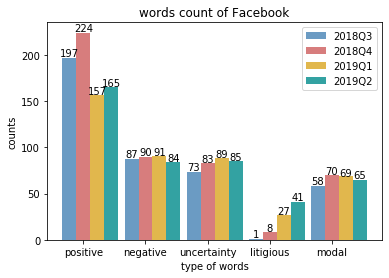

In [30]:
facebook_q1=small_data[(small_data['company_name']=='FB')&(small_data['quarter']==1)]#2019Q1
facebook_q2=small_data[(small_data['company_name']=='FB')&(small_data['quarter']==2)]#2019Q2
facebook_q3=small_data[(small_data['company_name']=='FB')&(small_data['quarter']==3)]#2018Q3
facebook_q4=small_data[(small_data['company_name']=='FB')&(small_data['quarter']==4)]#2018Q4
x=['positive','negative','uncertainty','litigious','modal']
y_1=facebook_q3.iloc[0,3:8]
y_2=facebook_q4.iloc[0,3:8]
y_3=facebook_q1.iloc[0,3:8]
y_4=facebook_q2.iloc[0,3:8]
bar_width=0.225
#from http://c.biancheng.net/view/2716.html
plt.bar(x=np.arange(len(x))-bar_width, height=y_1, label='2018Q3',color='steelblue', alpha=0.8, width=bar_width)
plt.bar(x=x, height=y_2,
    label='2018Q4', color='indianred', alpha=0.8, width=bar_width)
plt.bar(x=np.arange(len(x))+bar_width, height=y_3,
    label='2019Q1', color='goldenrod', alpha=0.8, width=bar_width)
plt.bar(x=np.arange(len(x))+2*bar_width, height=y_4,
    label='2019Q2', color='darkcyan', alpha=0.8, width=bar_width)
for x, y in enumerate(y_1):
    plt.text(x-bar_width, y, '%s' % y, ha='center', va='bottom')
for x, y in enumerate(y_2):
    plt.text(x, y+10, '%s' % y, ha='center', va='top')
for x, y in enumerate(y_3):
    plt.text(x+bar_width, y+9, '%s' % y, ha='center', va='top')
for x, y in enumerate(y_4):
    plt.text(x+2*bar_width, y+10, '%s' % y, ha='center', va='top')
plt.title("words count of Facebook")
plt.xlabel("type of words")
plt.ylabel("counts")
plt.legend()
plt.show()

###  Overview of average scores over states in U.S.

Before we train models to predict the results, we found that it may be interesting to see if there is any pattern of peopel/company giving speech for different states.    
In the following section, we catogorize the generated data by the location of company headquater. The data out of United States are ignored in the section.     
The location of the company headquater is store in the <i> company_info.csv</i>. 

On top of conducting analysis, we first created a dictionary that maps that full name of the states in the US to their abbreviation.    

**Reference** Get USA State Abbreviations from(https://abbreviations.yourdictionary.com/articles/state-abbrev.html)

In [31]:
us_state_abbrev = {
    'Alabama': 'AL',
    'Alaska': 'AK',
    'Arizona': 'AZ',
    'Arkansas': 'AR',
    'California': 'CA',
    'Colorado': 'CO',
    'Connecticut': 'CT',
    'Delaware': 'DE',
    'District of Columbia': 'DC',
    'Florida': 'FL',
    'Georgia': 'GA',
    'Hawaii': 'HI',
    'Idaho': 'ID',
    'Illinois': 'IL',
    'Indiana': 'IN',
    'Iowa': 'IA',
    'Kansas': 'KS',
    'Kentucky': 'KY',
    'Louisiana': 'LA',
    'Maine': 'ME',
    'Maryland': 'MD',
    'Massachusetts': 'MA',
    'Michigan': 'MI',
    'Minnesota': 'MN',
    'Mississippi': 'MS',
    'Missouri': 'MO',
    'Montana': 'MT',
    'Nebraska': 'NE',
    'Nevada': 'NV',
    'New Hampshire': 'NH',
    'New Jersey': 'NJ',
    'New Mexico': 'NM',
    'New York': 'NY',
    'North Carolina': 'NC',
    'North Dakota': 'ND',
    'Northern Mariana Islands':'MP',
    'Ohio': 'OH',
    'Oklahoma': 'OK',
    'Oregon': 'OR',
    'Palau': 'PW',
    'Pennsylvania': 'PA',
    'Puerto Rico': 'PR',
    'Rhode Island': 'RI',
    'South Carolina': 'SC',
    'South Dakota': 'SD',
    'Tennessee': 'TN',
    'Texas': 'TX',
    'Utah': 'UT',
    'Vermont': 'VT',
    'Virgin Islands': 'VI',
    'Virginia': 'VA',
    'Washington': 'WA',
    'West Virginia': 'WV',
    'Wisconsin': 'WI',
    'Wyoming': 'WY',
    'D.C.': 'DC',
}

In [32]:
total_data=small_data.merge(symbols_table, how="inner", left_on = "company_name", right_on="Symbol")

In [33]:
# Calculate average positive score for each state
state_pos_score_sum = {}#positive
state_neg_score_sum = {}#negative
state_unc_score_sum = {}#uncertainty
state_lit_score_sum = {}#litigious
state_mod_score_sum = {}#modal
state_compy_num = {}

In [34]:
for index, row in total_data.iterrows():
    state=row['Headquarters Location'].split(",")[1].strip()
    if state in state_pos_score_sum.keys(): 
        curr_pos_score = float(state_pos_score_sum.get(state))
        curr_neg_score = float(state_neg_score_sum.get(state))
        curr_unc_score = float(state_unc_score_sum.get(state))
        curr_lit_score = float(state_lit_score_sum.get(state))
        curr_mod_score = float(state_mod_score_sum.get(state))
        curr_num = float(state_compy_num.get(state))
        
        curr_pos_score += float(row['positive']/row['total_words'])
        curr_neg_score += float(row['negative']/row['total_words'])
        curr_unc_score += float(row['uncertainty']/row['total_words'])
        curr_lit_score += float(row['litigious']/row['total_words'])
        curr_mod_score += float(row['modal']/row['total_words'])
        curr_num += 1
    else: 
        curr_pos_score = row['positive']/row['total_words']
        curr_neg_score = row['negative']/row['total_words']
        curr_unc_score = row['uncertainty']/row['total_words']
        curr_lit_score = row['litigious']/row['total_words']
        curr_mod_score = row['modal']/row['total_words']
        curr_num = 1
        
    state_pos_score_sum.update({state: curr_pos_score})
    state_neg_score_sum.update({state: curr_neg_score})
    state_unc_score_sum.update({state: curr_unc_score})
    state_lit_score_sum.update({state: curr_lit_score})
    state_mod_score_sum.update({state: curr_mod_score})
    state_compy_num.update({state: curr_num})

In [35]:
state_avg_pos_score = {}
state_avg_neg_score = {}
state_avg_unc_score = {}
state_avg_lit_score = {}
state_avg_mod_score = {}

for key in state_pos_score_sum.keys():
    pos_score = float(state_pos_score_sum.get(key))
    neg_score = float(state_neg_score_sum.get(key))
    unc_score = float(state_unc_score_sum.get(key))
    lit_score = float(state_lit_score_sum.get(key))
    mod_score = float(state_mod_score_sum.get(key))
    num = float(state_compy_num.get(key))
    code = us_state_abbrev.get(key)
    state_avg_pos_score.update({code: pos_score/num})
    state_avg_neg_score.update({code: neg_score/num})
    state_avg_unc_score.update({code: unc_score/num})
    state_avg_lit_score.update({code: lit_score/num})
    state_avg_mod_score.update({code: mod_score/num})

**Reference** learn how to use Plotly from Plotly User Guide(https://plot.ly/python/v3/user-guide/)

In [94]:
fig = go.Figure(data=go.Choropleth(
    locations=list(state_avg_pos_score.keys()), # Spatial coordinates
    z = list(state_avg_pos_score.values()), # Data to be color-coded
    locationmode = 'USA-states', # set of locations match entries in `locations`
    colorscale = 'Greens',
    colorbar_title = "Positive Score",
))

fig.update_layout(
    title_text = 'Average positive score of Call Transcripts by State',
    geo_scope='usa', #  limite map scope to USA
)

fig.show()

In [37]:
fig = go.Figure(data=go.Choropleth(
    locations=list(state_avg_neg_score.keys()), # Spatial coordinates
    z = list(state_avg_neg_score.values()), # Data to be color-coded
    locationmode = 'USA-states', # set of locations match entries in `locations`
    colorscale = 'Reds',
    colorbar_title = "Negative Score",
))

fig.update_layout(
    title_text = 'Average negative score of Call Transcripts by State',
    geo_scope='usa', #  limite map scope to USA
)

fig.show()

In [91]:
fig = go.Figure(data=go.Choropleth(
    locations=list(state_avg_unc_score.keys()), # Spatial coordinates
    z = list(state_avg_unc_score.values()), # Data to be color-coded
    locationmode = 'USA-states', # set of locations match entries in `locations`
    colorscale = 'Blues',
    colorbar_title = "Uncertainty Score",
))

fig.update_layout(
    title_text = 'Average uncertainty score of Call Transcripts by State',
    geo_scope='usa', #  limite map scope to USA
)

fig.show()

In [92]:
fig = go.Figure(data=go.Choropleth(
    locations=list(state_avg_lit_score.keys()), # Spatial coordinates
    z = list(state_avg_lit_score.values()), # Data to be color-coded
    locationmode = 'USA-states', # set of locations match entries in `locations`
    colorscale = 'Greys',
    colorbar_title = "Litigious Score",
))

fig.update_layout(
    title_text = 'Average litigious score of Call Transcripts by State',
    geo_scope='usa', #  limite map scope to USA
)

fig.show()

In [93]:
fig = go.Figure(data=go.Choropleth(
    locations=list(state_avg_mod_score.keys()), # Spatial coordinates
    z = list(state_avg_mod_score.values()), # Data to be color-coded
    locationmode = 'USA-states', # set of locations match entries in `locations`
    colorscale = 'Purples',
    colorbar_title = "Modal Score",
))

fig.update_layout(
    title_text = 'Average modal score of Call Transcripts by State',
    geo_scope='usa', #  limite map scope to USA
)

fig.show()

#### Data Visualization Conclusion
- The release of earnings call transcripts have an effect on the change of stock price.
- West coast companies  tend to have more negative words in their Earnings call transcript.In particular,Companies in Companies in Oregon tend to use most positive words
- Central region companies tend to have more negative words in their Earnings call transcript. In particular,Companies in Nebraska tend to use most negative words
- East coast companies tend to have more uncertain words in their Earnings call transcript.In particular, Companies in Florida tend to use most uncertain words
- East coast companies tend to have more litigious words in their Earnings call transcript.In particular, Companies in Florida tend to use most litigious words
- East coast companies tend to use more modal words. In particular, companies in Pennsylvania use most modal words

## Hypothesis Testing
Hypothesis Testing is an Statistical inference method. It is used to determine whether the differences between samples and samples, samples and populations are caused by sampling errors or essential differences. It first makes assumptions about the characteristics of the population, and then makes inferences about this assumption through statistical reasoning of sampling research and to decide whether to reject or to accept.

Now, we have 6 features in the previous step. And we decide to use the polarity score as their labels. But we are not sure whether they are all relevant to the label. Here, the features are independent variables and label is dependent variable. We can use hypothesis testing to test the correlation between features and label. So we are going to use Pearson’s Correlation Coefficient to test the correlation. Here we make an assumption that features and label have linear relationship, since Pearson’s Correlation Coefficient can only represent the linear relationship.

We use the pearson correlation test package in scipy. In this method, we make these hypothesises: H0: the two samples are independent. H1: there is a dependency between the samples. This method calcuate the p value. If p is larger than 0.05, we can assume they are independent. Otherwise, they are dependent.

**Reference** learn how to conduct hypothesis testing from (https://codingdisciple.com/hypothesis-testing-ANOVA-python.html)

### Get Feature

In [50]:
csv_file1 = "big_call_data.csv"
csv_feature = pd.read_csv(csv_file1, low_memory = False)
csv_df_feature = pd.DataFrame(csv_feature)

In [51]:
filename = csv_df_feature[['company_name', 'year', 'quarter']]
file_name=[]
# combine company name, year and quarter to match the transcript's name later
for i in filename.iterrows():
    s=i[1]['company_name']+(str)(i[1]['year'])+"Q"+(str)(i[1]['quarter'])
    file_name.append(s)
csv_df_feature['File_Name'] = file_name

### Label: Polarity Score -- Using TextBlob
TextBlob is a python library that can be used to process text. It can slove different kinds of text processing problems, such as tokenization and tagging. Here, we use TextBlob to generate sentimental score for each transcript. We define the transcripts that have the score higher than the average are positive transcripts. The ones that have lower-than-average score are negative transcripts.

In [52]:
path = "./S&P500_data"

files= os.listdir(path)
files.remove(".DS_Store")

Get all the transcripts to generate the polarity score. At the mean time, use the file name to match the feature in previous csv file. In order to get better result, we only use the text in question and answer part.

In [53]:
transcript=[]
feature=[]
f1=[]
f2=[]
f3=[]
f4=[]
f5=[]
f6=[]
f7=[]
count=0
for file in files:
    if not os.path.isdir(file):
        # match the file name with the 7 features
        f_name=re.sub(".txt", "", file)
        f1.append(csv_df_feature.loc[csv_df_feature['File_Name'] == f_name]['positive'].tolist()[0])
        f2.append(csv_df_feature.loc[csv_df_feature['File_Name'] == f_name]['negative'].tolist()[0])
        f3.append(csv_df_feature.loc[csv_df_feature['File_Name'] == f_name]['uncertainty'].tolist()[0])
        f4.append(csv_df_feature.loc[csv_df_feature['File_Name'] == f_name]['litigious'].tolist()[0])
        f5.append(csv_df_feature.loc[csv_df_feature['File_Name'] == f_name]['modal'].tolist()[0])
        f6.append(csv_df_feature.loc[csv_df_feature['File_Name'] == f_name]['total_words'].tolist()[0])
        f7.append(csv_df_feature.loc[csv_df_feature['File_Name'] == f_name]['participants'].tolist()[0])
        f = open(path+"/"+file, encoding='UTF-8')
        line = f.readline()
        s=""
        while line:
            line=line.lower()
            # only use the question and answer session to increase accuracy
            if line=="question-and-answer session\n":
                count=1
            if count==1:
                s=s+line+" "
            s=s+line+" "
            line = f.readline()
        
        f.close()
        transcript.append(s)
feature.append(f1)
feature.append(f2)
feature.append(f3)
feature.append(f4)
feature.append(f5)
feature.append(f6)
feature.append(f7)
f=np.array(feature)

Call Textblob.sentiment.polarity to generate polarity socre to indicate how positive or negative they are. And use average score as the threshod. Record positive class as 1, and negative class as -1.

In [54]:
score=[]
for i in transcript:
    blob = TextBlob(i)
    score.append(blob.sentiment.polarity)
# calculate average score
avg=sum(score)/len(score)

label=[]
# Create label: if score is equal to or higher than average, label as 1 (positive)
# If score is lower than average, label as -1 (negative)
for i in range(len(transcript)):
    if score[i]>=avg:
        label.append(1)
    elif score[i]<avg:
        label.append(-1)
label1=np.array(label)

Now, we've already got all the features and labels. We can use pearsonr in scipy.stats to calculate the correlation between each feature and label. It can both generate correlation and p-value

In [55]:
stats=[]
ps=[]
# calculate pearson correlation coefficient between label and each feature
for i in range(len(feature)):
    stat, p = pearsonr(feature[i],label1)
    stats.append(stat)
    ps.append(p)
print("positive: ", ps[0])
print("negative: ", ps[1])
print("uncertainty: ", ps[2])
print("litigious: ", ps[3])
print("modal: ", ps[4])
print("total_words: ", ps[5])
print("participants: ", ps[6])

positive:  6.382847712015502e-27
negative:  4.299561173411857e-06
uncertainty:  0.0007137067075235833
litigious:  0.39788403049479354
modal:  5.1659716890691695e-05
total_words:  0.08540302818746591
participants:  0.19841139966827817


From the result above, we can learn the p-value of postive words, negative words, uncertainty words and modal words are extremely small, which means they have strong correlation with our label. But litigious words, total_words, and participants have relative weak correlation. So we decide to drop the 3 features.

In [56]:
feature1=f.T
# drop the features that have low correlation coefficient
feature2=np.delete(feature1, [3, 5, 6], axis=1)

## Model Selection

Since the core of our task is classification, we tried several classification model. Here, we used scikit-learn library in python. It is a machine learning tool, which has a powerful capability processing various machine learning algorithm, including SVM, random forest and naive bayes. Specifically, we used SVM, Bayes, decision tree and nerual network for our model.

**Reference** learn how to use scikit-learn from(https://scikit-learn.org/stable/)

First, we need to seperate the dataset into train data and test data by train_test_split function in scikit learn

In [57]:
# use train_test_split to split dataset by 70% and 30%
X_train, X_test, y_train, y_test = train_test_split(feature2, label1, test_size=0.3, random_state=42)

### SVM
SVM is a supervised learning algorithm related to classification and also regression. Given instance one of the category in two categories. SVM represents all the instances as points. So it can map instance and make them seperate in space as wide as possible. With this, it can assign a new instance one of the category.

In [58]:
from sklearn import svm
clf = svm.SVC()
clf = clf.fit(X_train, y_train)
print("accuracy of train data: ", clf.score(X_train, y_train))
print("accuracy of test data: ", clf.score(X_test, y_test))

accuracy of train data:  1.0
accuracy of test data:  0.4797047970479705


/Users/xuziling/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning:

The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.



### Decision Tree
Decision Tree is a special tree structure. It can leverage tree-like graphs or decision models to support decision making, or in machine learning, it can be used to predict.

In [59]:
from sklearn import tree
dt = tree.DecisionTreeClassifier(max_depth=9)
dt = dt.fit(X_train, y_train)
print("accuracy of train data: ", dt.score(X_train, y_train))
print("accuracy of test data: ", dt.score(X_test, y_test))

accuracy of train data:  0.8904761904761904
accuracy of test data:  0.6014760147601476


### Neural Network
Neural network is built from abstracting the human neuron with the perspective of information processing. It is an algorithm that consists of a large number of nodes connected to each other. Each node represents a specific output function, and the connection between two nodes represents a weighted value for the signal passing through the connection. With the function and the changable parameters, neural network has powerful capability of computing and predicting.

In [90]:
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(60, 10), random_state=1)
mlp = mlp.fit(X_train, y_train)
print("accuracy of train data: ", mlp.score(X_train, y_train))
print("accuracy of test data: ", mlp.score(X_test, y_test))

accuracy of train data:  0.726984126984127
accuracy of test data:  0.7011070110701108


### Improvement: Tf-idf as feature

From the result above, the highest accuracy is achieved by neural network -- 70%. However, it is not very good. Although the correlations are high. We notice the accuracy may relate to some other factors insteaf of only correlation coefficient. So we are thinking about a way to improve the accuracy. Recall the third homework, we decide to use Tf-idf to generate our feature. Tf-idf is a statistical matrix that represents the importance of each word to the whole text. That can better reserve the feature of our transcripts

In [62]:
# preprocess the trasncripts to tokens
t1=np.array(transcript)
t1 = pd.DataFrame(t1,columns=['transcript'])
processed_t = t1['transcript'].map(preprocess)

In [63]:
def dummy_fun(doc):
    return doc

# Generate tfidf model
tfidf = TfidfVectorizer(
        analyzer='word',
        tokenizer=dummy_fun,
        preprocessor=dummy_fun,
        token_pattern=None)

In [64]:
# Generate tfidf matrix as feature
tran=[]
for i in processed_t:
    tran.append(i)
tf = tfidf.fit_transform(tran).toarray()

In [65]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(tf, label1, test_size=0.3, random_state=42)

In [66]:
clf1 = svm.SVC()
clf1 = clf1.fit(X_train1, y_train1)
print("accuracy of train data: ", clf1.score(X_train1, y_train1))
print("accuracy of test data: ", clf1.score(X_test1, y_test1))

/Users/xuziling/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning:

The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.



accuracy of train data:  0.5301587301587302
accuracy of test data:  0.4797047970479705


In [67]:
dt1 = tree.DecisionTreeClassifier(max_depth=9)
dt1 = dt1.fit(X_train1, y_train1)
print("accuracy of train data: ", dt1.score(X_train1, y_train1))
print("accuracy of test data: ", dt1.score(X_test1, y_test1))

accuracy of train data:  0.9444444444444444
accuracy of test data:  0.6457564575645757


In [79]:
mlp1 = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(50, 20), random_state=1)
mlp1 = mlp1.fit(X_train1, y_train1)
print("accuracy of train data: ", mlp1.score(X_train1, y_train1))
print("accuracy of test data: ", mlp1.score(X_test1, y_test1))

accuracy of train data:  1.0
accuracy of test data:  0.7601476014760148


## Conclusion
From the results above, SVM still gets the lowest accauracy, 47%. Decision Tree achieves the accuracy of 64% on test data, and neural network gest the best result, which is 76% on test data. Therefore, we choose neural network that got the highest accuracy. Here, we uses a confusion matrix plot to show the classification result of neural network.

Total number of example:  271


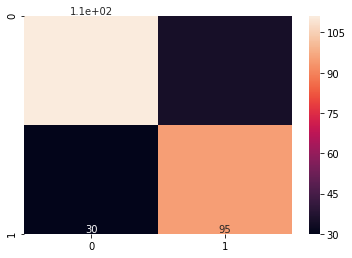

In [87]:
print("Total number of example: ", len(X_test1))
# Generate confusion matrix plot for neural network model
akws = {"ha": 'center',"va": 'bottom'}
sns.heatmap(sklearn.metrics.confusion_matrix(mlp1.predict(X_test1), y_test1), annot=True, annot_kws=akws)
plt.show()

There are totally 271 transcripts in test dataset. And 30 transcripts that are negative but are treated as positive. 36 transcripts that are actually positive but are treated as negative.

### Result Visualization
Now that we decide to use neural network to predict the sentiment. We can use the word cloud plot to see the result directly. Word cloud is a visualization tool for text data. It can show the importance of each word in a word list by showing the different size and color according to its frequency. Here, we want to in each class (positive transcriot and negative ttranscript), what is the difference between their word usage, and find the most frequent used word in each type of transcript.

In [73]:
# Predict the new labels for each transcript by neural network
result=mlp1.predict(tf)
l_po=np.argwhere(result == 1)
l_ne=np.argwhere(result == -1)

t1=[]
t2=[]
t=[]
for i in l_po:
    t1.append(transcript[i[0]])
for i in l_ne:
    t2.append(transcript[i[0]])
t.append(t1)
t.append(t2)

In [74]:
# define filter function to filter the words with very low or very high frequency
def get_words(dist):
    once= set()
    for k,v in dist.items():
        if v<2:
            once.add(k)
        if v>len(dist)*0.03:
            once.add(k)
    return once

In [75]:
# preprocess transcripts in each category
l_trans=[]
for tt in t:
    tt1=np.array(tt)
    tt1 = pd.DataFrame(tt1,columns=['transcript'])
    l_trans.append(tt1)

l_processed_trans=[]
for t in l_trans:
    processed_t = t['transcript'].map(preprocess)
    l_processed_trans.append(processed_t)

In [76]:
# filter the list of words
l_filtered=[]
for t in l_processed_trans:
    word=[]
    for t1 in t:
        word.extend(t1)
    count = Counter()
    count.update(word)
    u_words=get_words(count)
    filtered = [w for w in word if w not in u_words]
    l_filtered.append(filtered)

# transfer list of words to string for word cloud to use
l_text=[]
for f in l_filtered:
    text = " ".join(f)
    l_text.append(text)

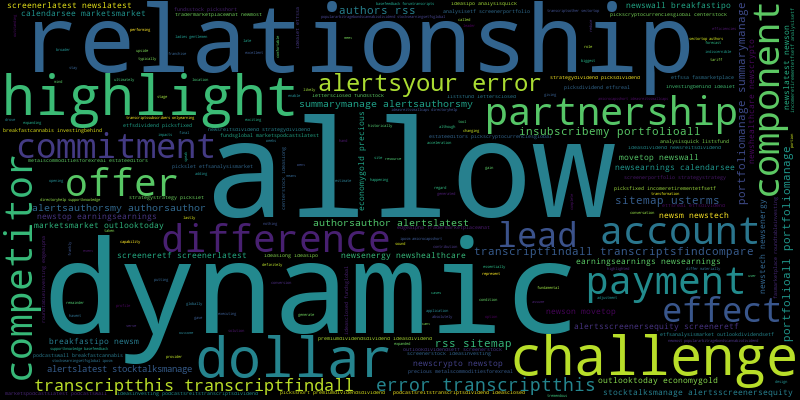

In [77]:
#Create word cloud plot for positive transcripts
wc1 = WordCloud(width=800,height=400).generate(re.sub(r"\s+"," ", l_text[0]))
wc1.to_image()

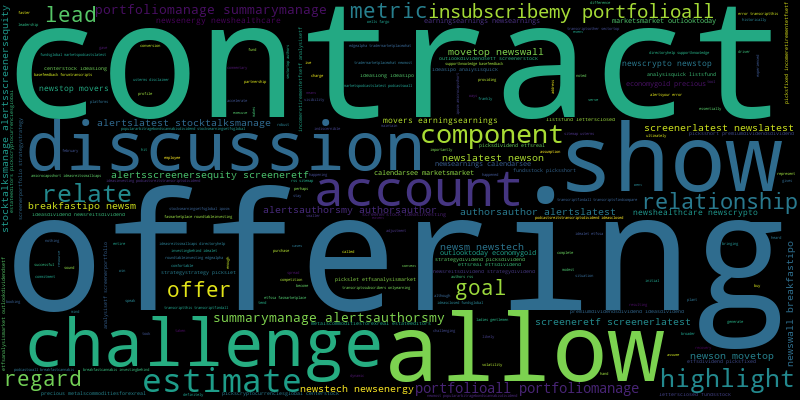

In [78]:
#Create word cloud plot for positive transcripts
wc2 = WordCloud(width=800,height=400).generate(re.sub(r"\s+"," ", l_text[1]))
wc2.to_image()

The first plot shows the words cluster in positive transcripts. The second plot shows the words in negative transcripts. All the transcripts are filtered by removing very high and very low frequency words. From the two plot, we can see some obvious differences. The words that show very frequently in positive transcripts are "dynamic", "dollar", "relationship" and etc.. The words that show frequently in negative transcripts are "contract", "offering", "challenge" and etc.. The means there actually exist the difference in word usage in positive and negative transcripts.

### Further Study

However, that doesn't mean our model is good enough to predict the sentiment of transcripts. After all, we only got 75% accuracy in the end. In the further study, we need to improve it through several approaches.

First, we need to process the transcripts more precisely. For example, now we only calculate the number of positive words and number of negative words. But "not good" has negative meaning and the weight for "very good" and "good" should be different. However, now we don't consider these. Maybe that could be the reason that we cannot get much higher accuracy. 

Second, now we only use single model to train our data. Sometimes, every model will have its shortcomings and cannot apply to all the cases. So in the future, we could use bagging and boosting for combine several models together to train. That might bring more precise results.

### Reference

- Data source:
    - Seeking Alpha(https://seekingalpha.com/earnings/earnings-call-transcripts)
    - The Motley Fool (https://www.fool.com/earnings-call-transcripts/)
    - Yahoo Finance(https://finance.yahoo.com/)
    - Loughran-McDonald Master Dictionary(https://sraf.nd.edu/textual-analysis/resources/)
    - State Abbreviations(https://abbreviations.yourdictionary.com/articles/state-abbrev.html)
- Referred documentation
    - Data scraping(https://jedgore.wordpress.com/2016/12/01/transcript-web-scraper-python/)
    - Conducting Hypothesis Testing(https://codingdisciple.com/hypothesis-testing-ANOVA-python.html)
    - Plotly User Guide(https://plot.ly/python/v3/user-guide/)
    - scikit-learn(https://scikit-learn.org/stable/)